In [24]:
import os
import glob
import numpy as np
from tensorflow.python.keras.preprocessing.image import  img_to_array, load_img
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [39]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
#%%
dict_labels = {"Front_close_TW":0, "Est_season_wind":1}
size = (128,128) #由於原始資料影像大小不一，因此制定一個統一值
nbofdata=100   #從各個資料夾中抓取特定數量的檔案
#%% Read Traget Folders' Path
labels=['01-03_Front_close_TW','05-07_Est_season_wind']
base_path = r'Weather/00_database/demo_02'
layers_of_folders=0
folder_list=[]
if base_path :
    folder_layers=[]
    files = os.scandir(base_path)
    #  Get the 1st layer of folder
    first_folder = []
    first_folder_kind = []
    for entry in files:
        if entry.is_dir():
            first_folder.append(entry.path)
            first_folder_kind.append(entry.name)
    folder_layers.append(first_folder_kind)
    folder_list.append(first_folder)
    #  Get the 2nd layer of folder
    second_folder = []
    if first_folder:
        second_folder = []
        second_folder_kind = []
        layers_of_folders+=1
        for fldr in first_folder:
            files = os.scandir(fldr)
            for entry in files:
                if entry.is_dir():
                    second_folder.append(entry.path)
                    second_folder_kind.append(entry.name)
        second_folder_kind= second_folder_kind[0:int(len(second_folder_kind)/len(first_folder_kind))]
        folder_layers.append(second_folder_kind)
        folder_list.append(second_folder)
    #  Get the 3rd layer of folder
    third_folder = []
    if second_folder:
        third_folder = []
        third_folder_kind = []
        layers_of_folders+=1
        for fldr in second_folder:
            files = os.scandir(fldr)
            for entry in files:
                if entry.is_dir():
                    third_folder.append(entry.path)
                    third_folder_kind.append(entry.name)
        third_folder_kind= third_folder_kind[0:int(len(third_folder_kind)/(len(second_folder_kind)*len(first_folder_kind)))]
        folder_list.append(third_folder)
    #  Get the 4th layer of folder
    forth_folder = []
    if third_folder:
        forth_folder = []
        forth_folder_kind = []
        layers_of_folders+=1
        for fldr in third_folder:
            files = os.scandir(fldr)
            for entry in files:
                if entry.is_dir():
                    forth_folder.append(entry.path)
                    forth_folder_kind.append(entry.name)
        forth_folder_kind= forth_folder_kind[0:int(len(forth_folder_kind)/(len(third_folder_kind)*len(second_folder_kind)*len(first_folder_kind)))]
        folder_list.append(forth_folder)
     #  Get the 5th layer of folder
    if forth_folder:
        fifth_folder = []
        fifth_folder_kind = []
        layers_of_folders+=1
        for fldr in third_folder:
            files = os.scandir(fldr)
            for entry in files:
                if entry.is_dir():
                    fifth_folder.append(entry.path)
                    fifth_folder_kind.append(entry.name)
        fifth_folder_kind= fifth_folder_kind[0:int(len(fifth_folder_kind)/(len(forth_folder_kind)*len(third_folder_kind)*len(second_folder_kind)*len(first_folder_kind)))]
#%% Read Image Files (*.tif)
datanumber=nbofdata
blob=[]
blob_nparray=[]
image_data=[]
conc = 0
labels_dict={}
for entry1 in folder_list[layers_of_folders - 1]:
    blob = []
    cellname = os.path.basename(os.path.dirname(entry1))  # extract cell name
    # print(cellname)
    concnames = os.path.basename(entry1)  # extract concentration
    # print(concnames)
    if concnames in labels:
        labels_dict[conc] = concnames
        fnamelist = glob.glob(os.path.join(entry1, '*.jpg'))
        for filename in fnamelist[0:datanumber]:
            im = Image.open(filename)
            if im is not None:
                if im.mode=='RGB':
                    im=im.resize(size,Image.BILINEAR)
                    imarray = np.array(im)
                    blob.append(imarray)
        ind = np.reshape(np.arange(1, len(blob) + 1), (-1, 1))
        blob_nparray = np.reshape(np.asarray(blob), (len(blob), blob[1].size))
        blob_nparray = np.hstack((blob_nparray, ind, conc * np.ones((len(blob), 1))))
        image_data.append(np.asarray(blob_nparray, dtype=np.float32))
        print(concnames+'  finished!')
        conc += 1
#%%
for j in range(len(labels)):
    trytry=image_data[j][:]
# Prepare data
    LengthT = trytry.shape[0]
    trytry_index = trytry[...,-2:-1]
    trytry_label = trytry[...,-1:] #['Nega' for x in range(lengthN*4)] #Nega_data[...,-1:]
    trytry = trytry[...,:-2]
    
    # Normalize image by subtracting mean image
    trytry -= np.reshape(np.mean(trytry, axis=1), (-1,1))
    # Reshape images
    trytry = np.reshape(trytry, (trytry.shape[0],128,128,3))
    
#    # Rotate images
#    for i in range(3):
#        trytry[LengthT*(i+1):LengthT*(i+2)] = np.rot90(trytry[:LengthT], i+1, (1,2))
    # Add channel dimension to fit in Conv2D
    trytry = trytry.reshape(-1,128,128,3)
    np.random.shuffle(trytry)
    trytry_train_upto = round(trytry.shape[0] * 8 / 10)
    trytry_test_upto = trytry.shape[0]
    if j is 0:
        train_data = trytry[:trytry_train_upto]
        test_data = trytry[trytry_train_upto:trytry_test_upto]
        train_label = trytry_label[:trytry_train_upto]
        test_label = trytry_label[trytry_train_upto:trytry_test_upto]
        
    else:
        train_data = np.concatenate((train_data, 
                                     trytry[:trytry_train_upto]), axis=0)
        
        test_data = np.concatenate((test_data, 
                                    trytry[trytry_train_upto:trytry_test_upto]), axis=0)
        
        train_label = np.concatenate((train_label, 
                                     trytry_label[:trytry_train_upto]), axis=0)
        
        
        test_label = np.concatenate((test_label, 
                                    trytry_label[trytry_train_upto:trytry_test_upto]), axis=0)
        
test_label = tf.keras.utils.to_categorical(test_label, num_classes=len(labels))
train_label = tf.keras.utils.to_categorical(train_label, num_classes=len(labels))

#%% Shuffle data
import random
temp = list(zip(train_data, train_label))

random.shuffle(temp)

train_data,train_label = zip(*temp)

train_data=np.asarray(train_data)
train_label=np.asarray(train_label)

#%% VGG 16 only for classification
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop
# Generate model
model = Sequential()
# input: 190x190 images with 3 channels -> (190, 190, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128,128,3),padding='same',name='block1_conv2_1'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name='block1_conv2_2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block1_MaxPooling'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',name='block2_conv2_1'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',name='block2_conv2_2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block2_MaxPooling'))
model.add(Dropout(0.25))
#
#model.add(Conv2D(256, (3, 3), activation='relu',padding='same',name='block3_conv2_1'))
#model.add(Conv2D(256, (3, 3), activation='relu',padding='same',name='block3_conv2_2'))
#model.add(Conv2D(256, (3, 3), activation='relu',padding='same',name='block3_conv2_3'))
#model.add(MaxPooling2D(pool_size=(2, 2),name='block3_MaxPooling'))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block4_conv2_1'))
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block4_conv2_2'))
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block4_conv2_3'))
#model.add(MaxPooling2D(pool_size=(2, 2),name='block4_MaxPooling'))
#model.add(Dropout(0.25))
#
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block5_conv2_1'))
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block5_conv2_2'))
#model.add(Conv2D(512, (3, 3), activation='relu',padding='same',name='block5_conv2_3'))
#model.add(MaxPooling2D(pool_size=(2, 2),name='block5_MaxPooling'))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu',name='final_output_1'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu',name='final_output_2'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax',name='class_output'))
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'
model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
EStop = EarlyStopping(monitor='val_acc', min_delta=0, 
                      patience=10, verbose=1, mode='auto')
model.summary()

05-07_Est_season_wind  finished!
01-03_Front_close_TW  finished!
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv2_1 (Conv2D)      (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2_2 (Conv2D)      (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_MaxPooling (MaxPoolin (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv2_1 (Conv2D)      (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2_2 (Conv2D)      (None, 64, 64, 128)       147584    
______________________________________________________

In [40]:
#%% Start Traning Model
history = model.fit(train_data, train_label, batch_size=64, epochs=40,shuffle=True, validation_split=0.2,callbacks=[EStop])
#%%
model.save('Weather_model_type_2022.h5') 

Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - ETA: 0s - loss: 60.9239 - accuracy: 0.4479WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fc36b9b1c20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and a

Epoch 23/40
2/2 [==============================] - 7s 3s/step - loss: 0.3590 - accuracy: 0.8500 - val_loss: 0.6286 - val_accuracy: 0.6400
Epoch 24/40
2/2 [==============================] - 7s 3s/step - loss: 0.2221 - accuracy: 0.9190 - val_loss: 1.0314 - val_accuracy: 0.5200
Epoch 25/40
2/2 [==============================] - 7s 3s/step - loss: 0.2919 - accuracy: 0.8863 - val_loss: 0.8296 - val_accuracy: 0.6400
Epoch 26/40
2/2 [==============================] - 7s 3s/step - loss: 0.1487 - accuracy: 0.9069 - val_loss: 0.6912 - val_accuracy: 0.6400
Epoch 27/40
2/2 [==============================] - 7s 3s/step - loss: 0.1439 - accuracy: 0.9258 - val_loss: 1.1972 - val_accuracy: 0.4800
Epoch 28/40
2/2 [==============================] - 7s 3s/step - loss: 0.1333 - accuracy: 0.9363 - val_loss: 0.7589 - val_accuracy: 0.6000
Epoch 29/40
2/2 [==============================] - 7s 3s/step - loss: 0.0583 - accuracy: 0.9794 - val_loss: 0.7557 - val_accuracy: 0.6400
Epoch 30/40
2/2 [=================

Text(0.5, 1.0, 'Training and validation loss')

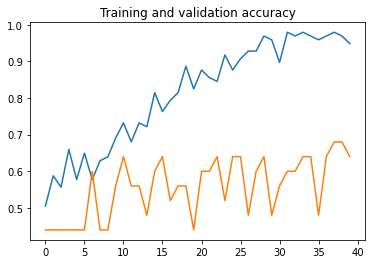

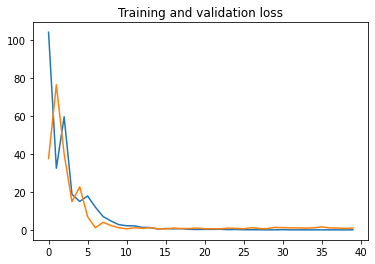

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
I am 98.34% sure this is Est_season_wind
1


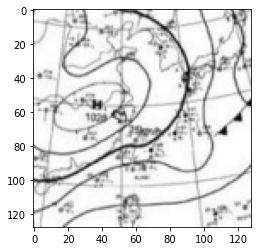

I am 88.20% sure this is Est_season_wind
2


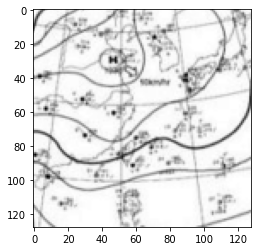

I am 50.25% sure this is Est_season_wind
3


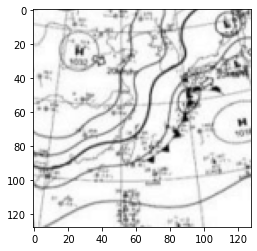

I am 93.66% sure this is Est_season_wind
4


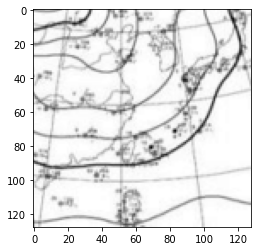

I am 91.71% sure this is Est_season_wind
5


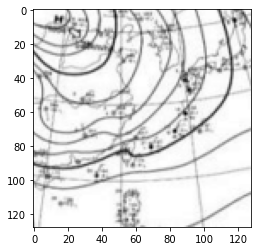

I am 88.04% sure this is Est_season_wind
6


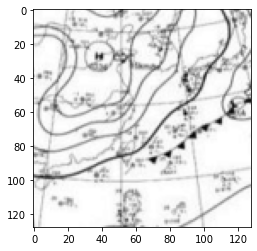

I am 98.03% sure this is Est_season_wind
7


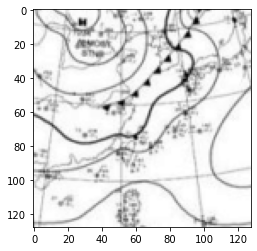

I am 83.73% sure this is Est_season_wind
8


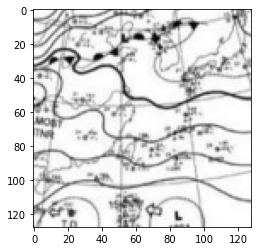

I am 91.24% sure this is Est_season_wind
9


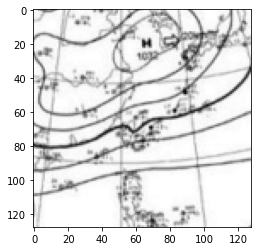

I am 98.07% sure this is Est_season_wind
10


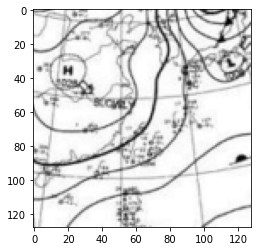

I am 96.61% sure this is Est_season_wind
11


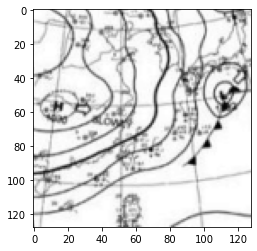

I am 87.10% sure this is Est_season_wind
12


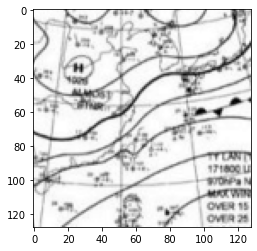

I am 97.06% sure this is Est_season_wind
13


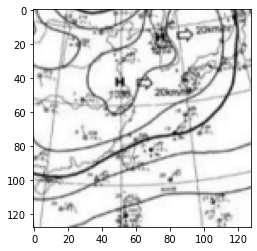

I am 96.41% sure this is Est_season_wind
14


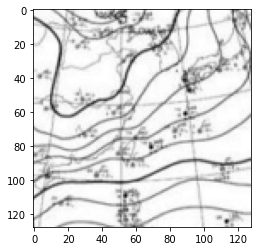

I am 99.25% sure this is Est_season_wind
15


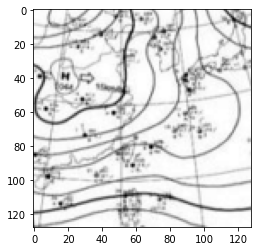

I am 97.84% sure this is Est_season_wind
16


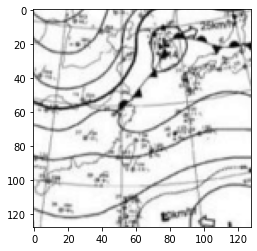

I am 88.66% sure this is Est_season_wind
17


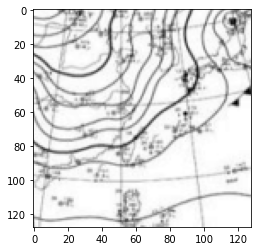

I am 95.44% sure this is Est_season_wind
18


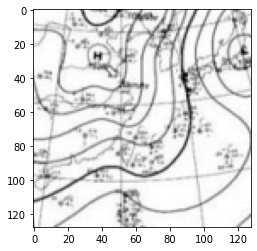

I am 97.67% sure this is Est_season_wind
19


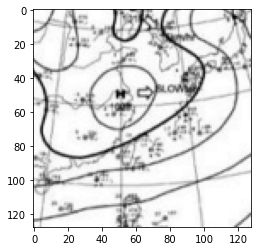

I am 91.92% sure this is Est_season_wind
20


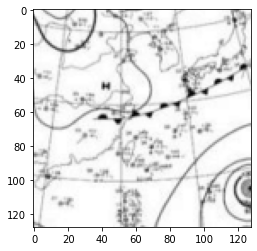

I am 93.45% sure this is Front_close_TW
21


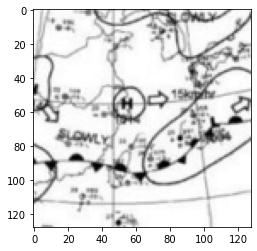

I am 95.50% sure this is Est_season_wind
22


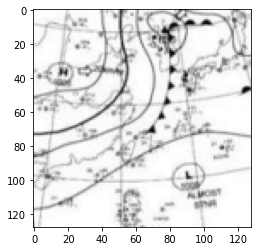

I am 80.77% sure this is Front_close_TW
23


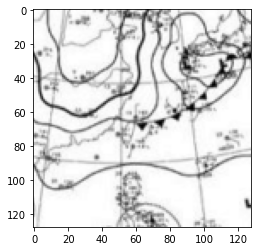

I am 64.35% sure this is Est_season_wind
24


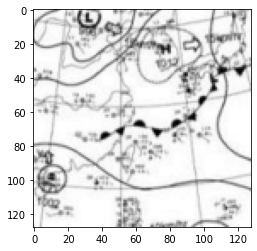

I am 57.78% sure this is Est_season_wind
25


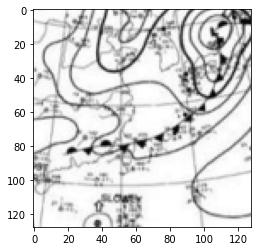

I am 74.69% sure this is Est_season_wind
26


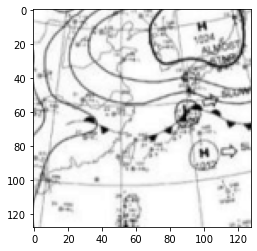

I am 71.71% sure this is Est_season_wind
27


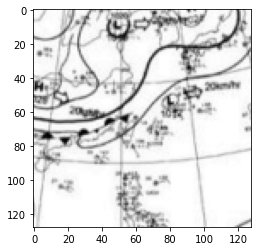

I am 90.62% sure this is Est_season_wind
28


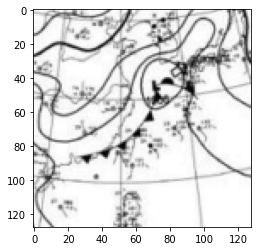

I am 90.85% sure this is Est_season_wind
29


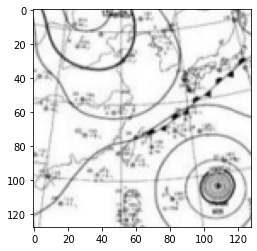

I am 78.39% sure this is Est_season_wind
30


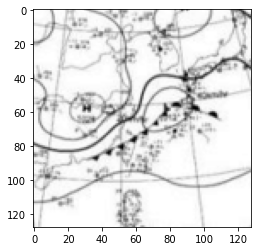

In [42]:
predictions=model.predict(test_data)
#%%
from random import randint
from tensorflow.python.keras.preprocessing.image import array_to_img
for i in range(1,31):
    if predictions[i, 1] >= 0.5: 
        print('I am {:.2%} sure this is Front_close_TW'.format(predictions[i][1]))
        print(i)
    else: 
        print('I am {:.2%} sure this is Est_season_wind'.format(1-predictions[i][1]))
        print(i)
    plt.imshow(array_to_img(test_data[i]))
    plt.show()

In [43]:
import pandas as pd
def plotLearningCurves(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(8,5))
    plt.grid(True) # 顯示網格
    plt.gca().set_ylim(0, 1)
    plt.show()

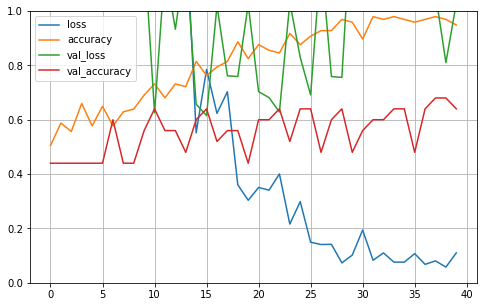

In [44]:
plotLearningCurves(history)

In [45]:
print(test_data,predictions,i,sep='\n',end='**')

[[[[  28.848022     28.848022     28.848022  ]
   [  28.848022     28.848022     28.848022  ]
   [  27.848022     27.848022     27.848022  ]
   ...
   [  23.848022     23.848022     23.848022  ]
   [  24.848022     24.848022     24.848022  ]
   [  24.848022     24.848022     24.848022  ]]

  [[  28.848022     28.848022     28.848022  ]
   [  28.848022     28.848022     28.848022  ]
   [  28.848022     28.848022     28.848022  ]
   ...
   [  22.848022     22.848022     22.848022  ]
   [  15.848022     15.848022     15.848022  ]
   [  24.848022     24.848022     24.848022  ]]

  [[  27.848022     27.848022     27.848022  ]
   [  27.848022     27.848022     27.848022  ]
   [  27.848022     27.848022     27.848022  ]
   ...
   [  15.848022     15.848022     15.848022  ]
   [   1.8480225     1.8480225     1.8480225 ]
   [  -5.1519775    -5.1519775    -5.1519775 ]]

  ...

  [[ -29.151978    -29.151978    -29.151978  ]
   [  20.848022     20.848022     20.848022  ]
   [  25.848022     25.848